# VdVp Plotting Tool (Part 1)

This program calculates the VdVp ratio at every residue position of a protein using a bin length defined by the user. To run the code, please enter the following parameters into the cell below and then hit run all:

1. Path to csv file downloaded from gnomad
2. Length of the protein
3. Percentage of protein length to set as bin width
4. Path to save the raw data used to generate a VdVp ratio plot

In [125]:
#1. Path to csv file
gnomad_csv = pd.read_csv('/Users/gaurideak/Desktop/testing/input.csv')

#2. Length of the protein
protein_length = 853

#3. Bin width
bin_width = protein_length*0.02

#4. Path to save the raw data used to generate a VdVp ratio plot as a txt file
export_table_path = '/Users/gaurideak/Desktop/testing/output.txt'


In [126]:
#Part 1: Filters gnomad data and extracts missense variants

#Downloads pre-requisites
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def filter_data(gnomad_csv):
    #Converts gnomad csv file to dataframe
    gnomad_frame = gnomad_csv

    #Selects relevant columns and renames them with underscores
    gnomad_frame = gnomad_frame[['Position','rsIDs','Filters - exomes',\
                                 'Protein Consequence','VEP Annotation',\
                                 'ClinVar Clinical Significance',\
                                 'Allele Frequency']]
    cols = ['Position','rsID','Filters_exomes','Protein_Consequence',\
            'VEP_Annotation','ClinVar_Clinical_Significance','Allele_Frequency']
    gnomad_frame.columns = cols

    #Filters for missense variants from exome sequencing data
    gnomad_frame =gnomad_frame[gnomad_frame['VEP_Annotation']=='missense_variant']
    gnomad_frame =gnomad_frame[gnomad_frame['Filters_exomes']=='PASS']
    gnomad_frame = gnomad_frame.drop(['VEP_Annotation','Filters_exomes'],axis=1)

    #Filters out potentially pathogenic variants
    ClinVar = ['Uncertain significance','Likely pathogenic','Pathogenic',\
               'Conflicting interpretations of pathogenicity']
    gnomad_frame = gnomad_frame[~gnomad_frame.ClinVar_Clinical_Significance.\
                                isin(ClinVar)]
    gnomad_frame = gnomad_frame.drop(['ClinVar_Clinical_Significance'],axis=1)

    #Reduces filtered dataframe to residue numbers extracted from the Protein_Consequence column
    #Converts the numbers to type numeric
    gnomad_frame = gnomad_frame.Protein_Consequence.str.extract('(\d+)')
    gnomad_frame.columns = ['Res_Num']
    gnomad_frame['Res_Num'] = pd.to_numeric(gnomad_frame['Res_Num'])
    return gnomad_frame

data = filter_data(gnomad_csv)

#Gets variant residue numbers
protein_variants = data.to_numpy()


In [127]:
#Part 2: Calculates the VdVp values for each bin

#Calculates the Vp
def calculator(variants, length):
    (unique, counts) = np.unique(variants, return_counts=True)
    return len(counts)/int(length)

Vp = calculator(protein_variants,protein_length)

#Defines lists of bin starts and ends using user-specified range
#Currently, bin width = 5 

bin_start = list(np.arange(1,protein_length,1))
bin_end = list(np.arange(bin_width,protein_length,1))

#Creates empty list of bin lengths
bin_length = []

#Loops through each start-end combination along the protein to get bin lengths
for start,end in zip(bin_start,bin_end):
    bin_length.append(end - start + 1)

#Calculates the Vd/Vp for each bin
VdVp = []

for start,end,length in zip(bin_start,bin_end,bin_length):
    variants = data[(data['Res_Num'] >= start) & (data['Res_Num'] < end)]
    (unique, counts) = np.unique(variants, return_counts=True)
    VdVp.append((len(counts)/length)/Vp)

Vp =  0.27


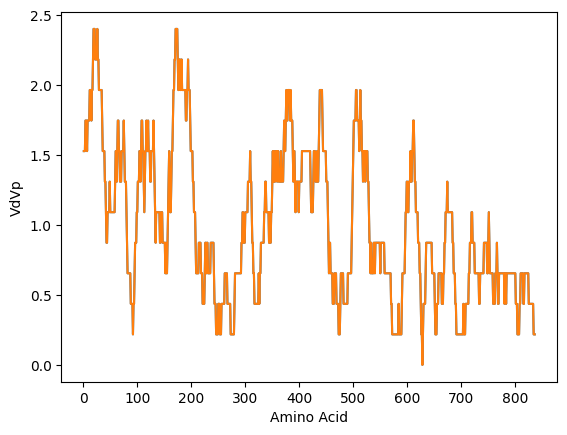

In [128]:
#Part 3: Generates a plot of VdVp values along the protein sequence

#Prints Vp value above plot
print('Vp = ',round(Vp,2))

#Defines the last residue of the protein in the analysis
last_res = protein_length - (bin_width-1)

#Creates range of residues for x-axis in plot
residues = np.arange(1,last_res)

#Generates dataframe where x = residue number and y = VdVp
export_table = pd.DataFrame(list(zip(residues, VdVp)),
               columns =['Residue', 'VdVp'])

#Exports dataframe to csv
export_table.to_csv(export_table_path, index=False)

#Generates preview of plot
sns.lineplot(x = residues, y = VdVp)
plt.plot(residues, VdVp)
plt.xlabel('Amino Acid')
plt.xticks(np.arange(0, protein_length, step=100))
plt.ylabel('VdVp')
plt.show()
